In [1]:
import boto3
import io
import urllib
import s3fs
import json
from pathlib import Path
import attr
import numpy
import tiledb
import tiledb.cloud
from tiledb.cloud.compute import DelayedArrayUDF, Delayed
import pandas
import geopandas
import fiona
from fiona.session import AWSSession
import pystac
from scipy.stats import skew, kurtosis
import uuid
from numba import jit
import gc
from vincenty import vincenty

In [2]:
import pystac
from pystac.extensions.projection import ProjectionExtension
from pystac.extensions.pointcloud import (
PointcloudExtension,
SchemaType,
PhenomenologyType,
Schema,
Statistic,
)

In [3]:
from reap_gsf import reap, data_model
from bathy_datasets import rhealpix, storage, geometry, asb_spreadsheet,stac_metadata

In [4]:
session = boto3.Session()
creds = session.get_credentials()

In [5]:
fs = s3fs.S3FileSystem(key=creds.access_key, secret=creds.secret_key, use_listings_cache=False)

In [6]:
uid = uuid.uuid4()

In [7]:
survey_uri = "s3://ausseabed-pl019-provided-data/DeakinUniversity/Bunurong_MNP/"
outdir_uri = "s3://ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/"
asb_metadata_uri = "s3://ausseabed-pl019-provided-data/DeakinUniversity/Bunurong_MNP/metadata/spreadsheet-metadata.json"
survey_info_uri = "s3://ausseabed-pl019-provided-data/DeakinUniversity/Bunurong_MNP/schema-info.json"

In [8]:
base_prefix = "ga_ausseabed"
array_name = f"{base_prefix}_{uid}_bathymetry"
array_uri = f"{outdir_uri}{array_name}.tiledb"
tiledb_array_uri = f"tiledb://sixy6e/{array_name}"
soundings_cell_density_uri = f"{outdir_uri}{base_prefix}_{uid}_soundings-cell-density-resolution-12.geojson"
coverage_uri = f"{outdir_uri}{base_prefix}_{uid}_coverage.geojson"
stac_md_uri = f"{outdir_uri}{base_prefix}_{uid}_stac-metadata.geojson"

In [9]:
soundings_cell_density_uri_15 = f"{outdir_uri}{base_prefix}_{uid}_soundings-cell-density-resolution-15.geojson"
soundings_cell_density_array_uri_15 = f"{outdir_uri}{base_prefix}_{uid}_soundings-cell-density-resolution-15.tiledb"
soundings_cell_density_sparse_array_uri_15 = f"{outdir_uri}{base_prefix}_{uid}_soundings-cell-density-resolution-15-sparse-array.tiledb"

In [10]:
res12_out_uri_sparse = f"{outdir_uri}{base_prefix}_{uid}_soundings-cell-density-resolution-12-sparse-array.tiledb"
res12_out_uri_dense = f"{outdir_uri}{base_prefix}_{uid}_soundings-cell-density-resolution-12-dense-array.tiledb"

In [11]:
tmpdir = f"{outdir_uri}{base_prefix}_{uid}_tmp/"

In [12]:
tmpdir

's3://ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/ga_ausseabed_b156a91a-43f1-4ad3-ba5c-8641044acbca_tmp/'

In [13]:
array_uri

's3://ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/ga_ausseabed_b156a91a-43f1-4ad3-ba5c-8641044acbca_bathymetry.tiledb'

In [14]:
def get_sonar_metadata(json_uri):
    """
    Temporary func for pulling metadata from a sample GSF file.
    """
    with fs.open(json_uri) as src:
        md = json.loads(src.read())
    stream_task = Delayed("sixy6e/retrieve_stream", name="retrieve")(md["gsf_uri"], creds.access_key, creds.secret_key)
    dataframe_task = Delayed("sixy6e/decode_gsf", name="decode", image_name="3.7-geo")(stream_task, slice(10))
    df, finfo = dataframe_task.compute()
    sonar_metadata = finfo[3].record(0).read(stream_task.result()[0])
    history = attr.asdict(finfo[6].record(0).read(stream_task.result()[0]))
    for key, value in history.items():
        sonar_metadata[key] = value
    return sonar_metadata


def reduce_region_codes_timestamps(results):
    """
    The reduce part of the map-reduce construct for handling the region_code counts.
    Combine all the region_code counts then summarise the results.
    """
    region_codes = [i[0] for i in results]
    timestamps = [i[1] for i in results]
    df = pandas.concat(region_codes)
    cell_count = df.groupby(["region_code"])["count"].agg("sum").to_frame("count").reset_index()
    
    timestamps_df = pandas.DataFrame(
        {
            "start_datetime": [i[0] for i in timestamps],
            "end_datetime": [i[1] for i in timestamps],
        }
    )

    start_end_timestamp = [
        timestamps_df.start_datetime.min().to_pydatetime(),
        timestamps_df.end_datetime.max().to_pydatetime(),
    ]

    return cell_count, start_end_timestamp


def reduce_region_codes(region_codes):
    """
    The reduce part of the map-reduce construct for handling the region_code counts.
    Combine all the region_code counts then summarise the results.
    """
    df = pandas.concat(region_codes)
    cell_count = df.groupby(["region_code"])["count"].agg("sum").to_frame("count").reset_index()

    return cell_count


def reduce_timestamps(timestamps):
    """
    The reduce part of the map-reduce construct for handling the region_code counts.
    Combine all the region_code counts then summarise the results.
    """
    timestamps_df = pandas.DataFrame(
        {
            "start_datetime": [i[0] for i in timestamps],
            "end_datetime": [i[1] for i in timestamps],
        }
    )

    start_end_timestamp = [
        timestamps_df.start_datetime.min().to_pydatetime(),
        timestamps_df.end_datetime.max().to_pydatetime(),
    ]

    return start_end_timestamp


def gather_stats(results):
    """
    Gather the results from all the stats tasks and
    combine into a single dict.
    """
    data = {}
    for item in results:
        for key in item:
            data[key] = item[key]
    return data

In [15]:
def retrieve_stream(uri, access_key, skey):
    """
    Not testing the creation of the stream object at this point.
    But for testing, we also need to keep the download to occur only
    once.
    """
    session = boto3.Session(aws_access_key_id=access_key, aws_secret_access_key=skey)
    dev_resource = session.resource("s3")
    uri = urllib.parse.urlparse(uri)
    obj = dev_resource.Object(bucket_name=uri.netloc, key=uri.path[1:])
    stream = io.BytesIO(obj.get()["Body"].read())
    return stream, obj.content_length


def append_ping_dataframe(dataframe, array_uri, access_key, skey):
    """Append the ping dataframe read from a GSF file."""
    config = tiledb.Config(
        {"vfs.s3.aws_access_key_id": access_key, "vfs.s3.aws_secret_access_key": skey}
    )
    ctx = tiledb.Ctx(config=config)
    kwargs = {
        "mode": "append",
        "sparse": True,
        "ctx": ctx,
    }

    tiledb.dataframe_.from_pandas(array_uri, dataframe, **kwargs)


def write_ping_beam_dims_dataframe(dataframe, array_uri, access_key, skey):
    """
    Write the ping dataframe to a TileDB using a dense ping-beam dimensional
    axes.
    """
    config = tiledb.Config(
        {"vfs.s3.aws_access_key_id": access_key, "vfs.s3.aws_secret_access_key": skey}
    )
    ctx = tiledb.Ctx(config=config)

    ping_start_idx = int(dataframe.ping_number.min())
    ping_end_idx = int(dataframe.ping_number.max()) + 1

    col_info = tiledb.dataframe_._get_column_infos(dataframe, None, None)
    data_dict, _nanull = tiledb.dataframe_._df_to_np_arrays(dataframe, col_info, None)

    with tiledb.open(array_uri, "w", ctx=ctx) as ds:
        ds[ping_start_idx:ping_end_idx, :] = data_dict


def ingest_gsf_slice(
    file_record,
    stream,
    access_key,
    skey,
    array_uri,
    idx=slice(None),
    cell_frequency=False,
    ping_beam_dims=False
):
    """
    General steps:
    Extract the ping data.
    Calculate the rHEALPIX code.
    Summarise the rHEALPIX codes (frequency count).
    Get timestamps of first and last pings.
    Write the ping data to a TileDB array.
    res = [df.groupby(["key"])["key"].agg("count").to_frame("count").reset_index() for i in range(3)]
    df2 = pandas.concat(res)
    df2.groupby(["key"])["count"].agg("sum")
    """
    swath_pings = data_model.SwathBathymetryPing.from_records(file_record, stream, idx)
    swath_pings.ping_dataframe["region_code"] = rhealpix.rhealpix_code(
        swath_pings.ping_dataframe.X, swath_pings.ping_dataframe.Y, 15
    )

    # frequency of dggs cells
    if cell_frequency:
        cell_count = (
            swath_pings.ping_dataframe.groupby(["region_code"])["region_code"]
            .agg("count")
            .to_frame("count")
            .reset_index()
        )

        start_end_time = [
            swath_pings.ping_dataframe.timestamp.min().to_pydatetime(),
            swath_pings.ping_dataframe.timestamp.max().to_pydatetime(),
        ]

    else:
        cell_count = None
        start_end_time = None

    # write to tiledb array
    if ping_beam_dims:
        write_ping_beam_dims_dataframe(swath_pings.ping_dataframe, array_uri, access_key, skey)
    else:
        append_ping_dataframe(swath_pings.ping_dataframe, array_uri, access_key, skey)

    # append_ping_dataframe(swath_pings.ping_dataframe, array_uri, access_key, skey)

    return cell_count, start_end_time


def ingest_gsf_slices(gsf_uri, access_key, skey, array_uri, slices, cell_frequency=False, ping_beam_dims=False):
    """
    Ingest a list of ping slices from a given GSF file.
    """
    stream, stream_length = retrieve_stream(gsf_uri, access_key, skey)
    finfo = reap.file_info(stream, stream_length)
    ping_file_record = finfo[1]

    cell_counts = []
    start_end_timestamps = []

    for idx in slices:
        count, start_end_time = ingest_gsf_slice(
            ping_file_record, stream, access_key, skey, array_uri, idx, cell_frequency, ping_beam_dims
        )
        cell_counts.append(count)
        start_end_timestamps.append(start_end_time)

    if cell_frequency:
        # aggreate the ping slices and calculate the cell counts
        concatenated = pandas.concat(cell_counts)
        cell_count = (
            concatenated.groupby(["region_code"])["count"]
            .agg("sum")
            .to_frame("count")
            .reset_index()
        )

        # aggregate the min and max timestamps, then find the min max timestamps
        timestamps_df = pandas.DataFrame(
            {
                "start_datetime": [i[0] for i in start_end_timestamps],
                "end_datetime": [i[1] for i in start_end_timestamps],
            }
        )

        start_end_timestamp = [
            timestamps_df.start_datetime.min().to_pydatetime(),
            timestamps_df.end_datetime.max().to_pydatetime(),
        ]

    else:
        cell_count = None
        start_end_timestamp = None

    return cell_count, start_end_timestamp

In [16]:
def dummy_reducer(results):
    return len(results)

def scatter(iterable, n):
    """
    Evenly scatters an interable by `n` blocks.
    Sourced from:
    http://stackoverflow.com/questions/2130016/splitting-a-list-of-arbitrary-size-into-only-roughly-n-equal-parts

    :param iterable:
        An iterable or preferably a 1D list or array.

    :param n:
        An integer indicating how many blocks to create.

    :return:
        A `list` consisting of `n` blocks of roughly equal size, each
        containing elements from `iterable`.
    """

    q, r = len(iterable) // n, len(iterable) % n
    res = (iterable[i * q + min(i, r) : (i + 1) * q + min(i + 1, r)] for i in range(n))
    return list(res)

In [17]:
def cell_frequency(array_uri, cell_frequency_uri, access_key, skey):
    """
    Calculate the frequency distirbution of each region code (cell count).
    Result is written to a tiledb array.
    """
    config = tiledb.Config(
        {"vfs.s3.aws_access_key_id": access_key, "vfs.s3.aws_secret_access_key": skey}
    )
    ctx = tiledb.Ctx(config=config)
    kwargs = {
        "sparse": False,
        "column_types": {
            "region_code": str,
            "count": numpy.uint64,
        },
        "ctx": ctx,
    }

    with tiledb.open(array_uri, ctx=ctx) as ds:
        query = ds.query(attrs=["region_code"], coords=False)
        df = query.df[:]

    frequency_df = (
        df.groupby(["region_code"])["region_code"]
        .agg("count")
        .to_frame("count")
        .reset_index()
    )

    tiledb.dataframe_.from_pandas(cell_frequency_uri, frequency_df, **kwargs)


def start_end_timestamps(array_uri, access_key, skey):
    """
    Find the min/max of the timestamp attribute.
    """
    config = tiledb.Config(
        {"vfs.s3.aws_access_key_id": access_key, "vfs.s3.aws_secret_access_key": skey}
    )
    ctx = tiledb.Ctx(config=config)

    with tiledb.open(array_uri, ctx=ctx) as ds:
        query = ds.query(attrs=["timestamp"], coords=False)
        df = query.df[:]

    start_end_time = [
        df.timestamp.min().to_pydatetime(),
        df.timestamp.max().to_pydatetime(),
    ]

    return start_end_time

In [18]:
def ingest_gsfs_singular(files, processing_node_limit, ping_slice_step, slices_per_node, array_uris, cell_freq_uris, local=False, ping_beam_dims=False):
    """
    Prototype ingester. Multi-file method. Each GSF will have a corresponding TileDB array.
    After which all TileDB arrays will be merged into 1.
    """

    node_counter = 0
    tasks = []
    tasks_dict = {n: [] for n in range(processing_node_limit)}
    files_dict = {fname: [] for fname in files}
    cell_frequency_tasks = []
    # timestamps_tasks = []

    for enumi, pathname in enumerate(files):
        metadata_pathname = pathname.replace(".gsf", ".json")
        base_name = Path(pathname).stem
        with fs.open(metadata_pathname) as src:
            gsf_metadata = json.loads(src.read())

        ping_count = gsf_metadata["file_record_types"]["GSF_SWATH_BATHYMETRY_PING"]["record_count"]

        slices = [slice(start, start+ping_slice_step) for start in numpy.arange(0, ping_count, ping_slice_step)]
        slice_chunks = [slices[i:i+slices_per_node] for i in range(0, len(slices), slices_per_node)]

        array_uri = array_uris[enumi]
        cell_freq_uri = cell_freq_uris[enumi]

        for slice_chunk in slice_chunks:
            start_idx = slice_chunk[0].start
            end_idx = slice_chunk[-1].stop
            task_name = f"{base_name}-{start_idx}-{end_idx}-{node_counter}"
            
            if local:
                task = Delayed(ingest_gsf_slices, name=task_name, local=True)(gsf_metadata["gsf_uri"], creds.access_key, creds.secret_key, array_uri, slice_chunk, cell_frequency=False, ping_beam_dims=ping_beam_dims)
            else:
                task = Delayed("sixy6e/ingest_gsf_slices", name=task_name, image_name="3.7-geo", timeout=1800)(gsf_metadata["gsf_uri"], creds.access_key, creds.secret_key, array_uri, slice_chunk, cell_frequency=False, ping_beam_dims=ping_beam_dims)

            if len(tasks_dict[node_counter]):
                task.depends_on(tasks_dict[node_counter][-1])

            tasks.append(task)
            tasks_dict[node_counter].append(task)
            node_counter += 1

            files_dict[pathname].append(task)

            if node_counter == processing_node_limit:
                node_counter = 0

        if local:
            cell_freq_task = Delayed(cell_frequency, name=f"{base_name}-cell-frequency", local=True)(array_uri, cell_freq_uri, creds.access_key, creds.secret_key)
            # timestamp_task = Delayed(start_end_timestamps, name=f"{base_name}-start-end-timestamps", local=True)(array_uri, creds.access_key, creds.secret_key)
        else:
             cell_freq_task = Delayed("sixy6e/cell_frequency", name=f"{base_name}-cell-frequency")(array_uri, cell_freq_uri, creds.access_key, creds.secret_key)
            #timestamp_task = Delayed("sixy6e/start_end_timestamps", name=f"{base_name}-start-end-timestamps")(array_uri, creds.access_key, creds.secret_key)
        
        for dep in files_dict[pathname]:
            cell_freq_task.depends_on(dep)


        #timestamp_task = Delayed("sixy6e/start_end_timestamps", name=f"{base_name}-start-end-timestamps")(array_uri, creds.access_key, creds.secret_key)
        # timestamp_task.depends_on(cell_freq_task)

        cell_frequency_tasks.append(cell_freq_task)
        # timestamps_tasks.append(timestamp_task)


    # reduce_task = Delayed(reduce_timestamps, name="reduce-timestamps", local=True)(timestamps_tasks)
    reduce_task = Delayed(dummy_reducer, name="dummy-reducer", local=True)(cell_frequency_tasks)
    
    return reduce_task

In [19]:
def load_and_concat(array_uris, ctx, out_uri=None):
    def concat(array_uris, ctx):
        data = []

        for uri in array_uris:
            with tiledb.open(uri, ctx=ctx) as ds:
                data.append(ds.df[:])

        concatenated = pandas.concat(data, copy=False)

        return concatenated

    concatenated = concat(array_uris, ctx)
    summarised = concatenated.groupby(["region_code"])["count"].agg("sum").to_frame("count").reset_index()
    if out_uri is None:
        return summarised
    else:
        write_chunked(summarised, out_uri, ctx, chunks=1000000)

In [20]:
@jit(nopython=True)
def strtoint(s):
    return ord(s) - 48

@jit(nopython=True)
def _unpack_code(region_codes: numpy.ndarray, ncodes, res):
    resolutions = [str(f"R{i}") for i in range(res)]
    unpacked = {
        "R1": numpy.zeros(ncodes, dtype="uint8"),
        "R2": numpy.zeros(ncodes, dtype="uint8"),
        "R3": numpy.zeros(ncodes, dtype="uint8"),
        "R4": numpy.zeros(ncodes, dtype="uint8"),
        "R5": numpy.zeros(ncodes, dtype="uint8"),
        "R6": numpy.zeros(ncodes, dtype="uint8"),
        "R7": numpy.zeros(ncodes, dtype="uint8"),
        "R8": numpy.zeros(ncodes, dtype="uint8"),
        "R9": numpy.zeros(ncodes, dtype="uint8"),
        "R10": numpy.zeros(ncodes, dtype="uint8"),
        "R11": numpy.zeros(ncodes, dtype="uint8"),
        "R12": numpy.zeros(ncodes, dtype="uint8"),
        "R13": numpy.zeros(ncodes, dtype="uint8"),
        "R14": numpy.zeros(ncodes, dtype="uint8"),
        "R15": numpy.zeros(ncodes, dtype="uint8"),
    }
    r0 = numpy.zeros(ncodes, dtype="<U1")
    for i in range(ncodes):
        code = str(region_codes[i])
        r0[i] = code[0]
        for j in range(1, res):
            unpacked[resolutions[j]][i] = strtoint(code[j])
    return r0, unpacked

In [21]:
def unpack_code(region_codes: numpy.ndarray, dataframe=True):
    res = len(region_codes[0])
    region_codes = region_codes.astype(f"<U{len(region_codes[0])}")
    r0, unpacked = _unpack_code(region_codes, region_codes.shape[0], res)
    unpacked_dict = {"R0": r0}
    for key in unpacked:
        unpacked_dict[key] = unpacked[key]
    if dataframe:
        result = pandas.DataFrame(unpacked_dict)
    else:
        result = unpacked_dict
    return result

In [22]:
def reduce_resoltion(df, resolution=12, chunks=10000):
    def reduce_res(dataframe, resolution):
        res = resolution + 1
        reduced = pandas.DataFrame(
            {
                "region_code": dataframe.region_code.str[0:res],
                "count": dataframe["count"].values,
            }
        )

        return reduced
    
    def group_res(dataframe):
        return dataframe.groupby(["region_code"])["count"].agg("sum").to_frame("count").reset_index()

    idxs = [(start, start + chunks) for start in numpy.arange(0, df.shape[0], chunks)]
    idx0 = idxs[0]
    subset = df[idx0[0]:idx0[1]]
    base_reduced = group_res(reduce_res(subset, resolution))

    for idx in idxs[1:]:
        subset = df[idx[0]:idx[1]]
        reduced = reduce_res(subset, resolution)
        concatenated = pandas.concat([base_reduced, reduced], copy=False)
        base_reduced = group_res(concatenated)

    return base_reduced

In [23]:
def write_chunked(df, out_uri, ctx, chunks=10000):
    idxs = [(start, start + chunks) for start in numpy.arange(0, df.shape[0], chunks)]
    rows_written = 0
    kwargs = {
        "sparse": False,
        "column_types": {"region_code": str, "count": numpy.uint64},
        "ctx": ctx,
    }
    for idx in idxs:
        subset = df[idx[0]:idx[1]]
        kwargs["row_start_idx"] = rows_written
        tiledb.dataframe_.from_pandas(out_uri, subset, **kwargs)
        kwargs["mode"] = "append"
        rows_written += len(subset)


def write_sparse_rhealpix_chunked(df, out_uri, ctx, chunks=10000):
    """Requires the output array to have already been created."""
    idxs = [(start, start + chunks) for start in numpy.arange(0, df.shape[0], chunks)]
    kwargs = {
        "mode": "append",
        "sparse": True,
        "ctx": ctx,
    }
    for idx in idxs:
        subset = df[idx[0]:idx[1]]
        new_df = unpack_code(subset.region_code.values)
        new_df["region_code"] = subset.region_code.values
        new_df["count"] = subset["count"].values
        tiledb.dataframe_.from_pandas(out_uri, new_df, **kwargs)

In [24]:
def filter_empty_files(files):
    """
    Filter out GSF's containing no Pings so we don't attempt to process them.
    """
    empty_files = []
    non_empty_files = []

    for pathname in files:
        metadata_pathname = pathname.replace(".gsf", ".json")
        base_name = Path(pathname).stem
        with fs.open(metadata_pathname) as src:
            gsf_metadata = json.loads(src.read())

        ping_count = gsf_metadata["file_record_types"]["GSF_SWATH_BATHYMETRY_PING"]["record_count"]
        if ping_count == 0:
            empty_files.append(pathname)
        else:
            non_empty_files.append(pathname)

    return non_empty_files, empty_files


def filter_large_files(files, size_limit_mb):
    """
    Filter out GSF's that are large than size_limit_mb so that they're processed locally.
    """
    manageable_files = []
    large_files = []

    for pathname in files:
        metadata_pathname = pathname.replace(".gsf", ".json")
        base_name = Path(pathname).stem
        with fs.open(metadata_pathname) as src:
            gsf_metadata = json.loads(src.read())

        # filter large files before hand, so we can still pass them through here but process locally
        if (gsf_metadata["size"] / 1024 / 1024) > size_limit_mb:
            large_files.append(pathname)
        else:
            manageable_files.append(pathname)

    return manageable_files, large_files

In [25]:
def combine_tiledbs(array_uris, out_array_uri, access_key, skey):
    config = tiledb.Config(
        {"vfs.s3.aws_access_key_id": access_key, "vfs.s3.aws_secret_access_key": skey}
    )
    ctx = tiledb.Ctx(config=config)

    for array_uri in array_uris:
        with tiledb.open(array_uri, ctx=ctx) as ds:
            df = ds.df[:]

        append_ping_dataframe(df, out_array_uri, access_key, skey)

In [26]:
with fs.open(survey_info_uri) as src:
    survey_info = json.loads(src.read())

In [27]:
#required_attributes = survey_info["schemas"][0]
# this is temporary. better to have it defined internally. or programmatically derived as a union of all schemas from all pings
required_attributes = [
    # "X",
    # "Y",
    "Z",
    "across_track",
    "along_track",
    "beam_angle",
    "beam_angle_forward",
    "beam_flags",
    #"beam_number",
    "centre_beam",
    "course",
    "depth_corrector",
    "gps_tide_corrector",
    "heading",
    "heave",
    "height",
    "horizontal_error",
    "ping_flags",
    "pitch",
    "roll",
    "sector_number",
    "separation",
    "speed",
    "tide_corrector",
    "timestamp",
    "travel_time",
    "vertical_error",
    "region_code",
]

In [28]:
config = tiledb.Config(
        {"vfs.s3.aws_access_key_id": creds.access_key, "vfs.s3.aws_secret_access_key": creds.secret_key}
    )
config_dict = config.dict()
ctx = tiledb.Ctx(config=config)

In [35]:
files = fs.glob(survey_uri + "**.gsf")
len(files)

180

In [36]:
# filter and empty files
non_empty_files, empty_files = filter_empty_files(files)
len(non_empty_files), len(empty_files)

(174, 6)

In [22]:
with fs.open(files[0].replace(".gsf", ".json")) as src:
    sample_md = json.loads(src.read())

In [26]:
sample_md["file_record_types"]["GSF_SWATH_BATHYMETRY_PING"]["record_count"]

278

In [27]:
pings = []

In [29]:
for uri_name in files:
    with fs.open(uri_name.replace(".gsf", ".json")) as src:
        gsf_md = json.loads(src.read())
        pings.append(gsf_md["file_record_types"]["GSF_SWATH_BATHYMETRY_PING"]["record_count"])

In [30]:
pings_np = numpy.array(pings)

In [31]:
pings_np.max()

41846

In [32]:
pings_np.argmax()

13

In [33]:
import matplotlib.pyplot as plt

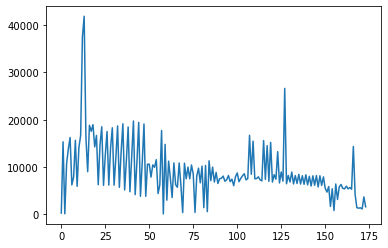

In [65]:
plt.plot(pings2_np)

In [35]:
pings_np.min()

0

In [27]:
#storage.create_mbes_array(array_uri, required_attributes, ctx)

In [28]:
#files = fs.glob(survey_uri + "**.gsf")
#len(files)

64

In [59]:
def process_pings(fname, creds, req_attrs, outdir, ctx):
    uri = f"s3://{fname}"
    pathname = Path(fname)
    stream, stream_length = retrieve_stream(uri, creds.access_key, creds.secret_key)
    finfo = reap.file_info(stream, stream_length)
    dataframes = []
    for i in range(finfo[1].record_count):
        idx = slice(i, i+1)
        swath_ping = data_model.SwathBathymetryPing.from_records(finfo[1], stream, idx=idx)
        swath_ping.ping_dataframe["ping_number"] = i
        dataframes.append(swath_ping.ping_dataframe)
        
    df = pandas.concat(dataframes)
    df["region_code"] = rhealpix.rhealpix_code(df.X.values, df.Y.values, 15)
    
    dom = ping_beam_domain(beam_tile_size=df.beam_number.max()+1, ping_domain_upper=df.ping_number.max(), beam_domain_upper=df.beam_number.max())
    attribs = mbes_attrs(req_attrs)
    schema = tiledb.ArraySchema(domain=dom, sparse=False, attrs=attribs, cell_order="row-major", tile_order="row-major", allows_duplicates=False)
    
    out_uri = outdir + pathname.stem + "/" + pathname.with_suffix(".tiledb").name
    with tiledb.scope_ctx(ctx):
        tiledb.Array.create(out_uri, schema)
        
    data_dict = {col: df[col].values for col in df.columns if col not in ["ping_number", "beam_number"]}
    with tiledb.open(out_uri, "w", ctx=ctx) as outds:
        outds[:, :] = data_dict

    #return df

In [55]:
def mbes_attrs(required_attributes=None):
    """Create the mbes attributes"""
    if required_attributes is None:
        required_attributes = []

    attribs = [
        tiledb.Attr("X", dtype=numpy.float64, filters=[tiledb.ZstdFilter(level=16)]),
        tiledb.Attr("Y", dtype=numpy.float64, filters=[tiledb.ZstdFilter(level=16)]),
        tiledb.Attr(
            "Z", dtype=numpy.float32, filters=[tiledb.ZstdFilter(level=16)]
        ),
        tiledb.Attr(
            "timestamp", dtype="datetime64[ns]", filters=[tiledb.ZstdFilter(level=16)]
        ),  # PDAL doesn't handle native datetimes. if requiring PDAL use numpy.int64
        tiledb.Attr(
            "across_track", dtype=numpy.float32, filters=[tiledb.ZstdFilter(level=16)]
        ),
        tiledb.Attr(
            "along_track", dtype=numpy.float32, filters=[tiledb.ZstdFilter(level=16)]
        ),
        tiledb.Attr(
            "travel_time", dtype=numpy.float32, filters=[tiledb.ZstdFilter(level=16)]
        ),
        tiledb.Attr(
            "beam_angle", dtype=numpy.float32, filters=[tiledb.ZstdFilter(level=16)]
        ),
        tiledb.Attr(
            "mean_cal_amplitude",
            dtype=numpy.float32,
            filters=[tiledb.ZstdFilter(level=16)],
        ),
        tiledb.Attr(
            "beam_angle_forward",
            dtype=numpy.float32,
            filters=[tiledb.ZstdFilter(level=16)],
        ),
        tiledb.Attr(
            "vertical_error", dtype=numpy.float32, filters=[tiledb.ZstdFilter(level=16)]
        ),
        tiledb.Attr(
            "horizontal_error",
            dtype=numpy.float32,
            filters=[tiledb.ZstdFilter(level=16)],
        ),
        tiledb.Attr(
            "sector_number",
            dtype=numpy.uint8,
            filters=[tiledb.RleFilter(), tiledb.ZstdFilter(level=16)],
        ),
        tiledb.Attr(
            "beam_flags",
            dtype=numpy.uint8,
            filters=[tiledb.RleFilter(), tiledb.ZstdFilter(level=16)],
        ),
        tiledb.Attr(
            "ping_flags",
            dtype=numpy.uint8,
            filters=[tiledb.RleFilter(), tiledb.ZstdFilter(level=16)],
        ),
        tiledb.Attr(
            "tide_corrector", dtype=numpy.float32, filters=[tiledb.ZstdFilter(level=16)]
        ),
        tiledb.Attr(
            "depth_corrector",
            dtype=numpy.float32,
            filters=[tiledb.ZstdFilter(level=16)],
        ),
        tiledb.Attr(
            "heading", dtype=numpy.float32, filters=[tiledb.ZstdFilter(level=16)]
        ),
        tiledb.Attr(
            "pitch", dtype=numpy.float32, filters=[tiledb.ZstdFilter(level=16)]
        ),
        tiledb.Attr("roll", dtype=numpy.float32, filters=[tiledb.ZstdFilter(level=16)]),
        tiledb.Attr(
            "heave", dtype=numpy.float32, filters=[tiledb.ZstdFilter(level=16)]
        ),
        tiledb.Attr(
            "course", dtype=numpy.float32, filters=[tiledb.ZstdFilter(level=16)]
        ),
        tiledb.Attr(
            "speed", dtype=numpy.float32, filters=[tiledb.ZstdFilter(level=16)]
        ),
        tiledb.Attr(
            "height", dtype=numpy.float32, filters=[tiledb.ZstdFilter(level=16)]
        ),
        tiledb.Attr(
            "separation", dtype=numpy.float32, filters=[tiledb.ZstdFilter(level=16)]
        ),
        tiledb.Attr(
            "gps_tide_corrector",
            dtype=numpy.float32,
            filters=[tiledb.ZstdFilter(level=16)],
        ),
        tiledb.Attr(
            "centre_beam", dtype=numpy.uint8, filters=[tiledb.RleFilter(), tiledb.ZstdFilter(level=16)]
        ),
        tiledb.Attr(
            "beam_number", dtype=numpy.uint16, filters=[tiledb.ZstdFilter(level=16)]
        ),
        tiledb.Attr(
            "region_code", dtype=str, filters=[tiledb.ZstdFilter(level=16)]
        ),
    ]

    attributes = [at for at in attribs if at.name in required_attributes]

    return attributes

In [31]:
# filter and empty files
non_empty_files, empty_files = filter_empty_files(files)
len(non_empty_files), len(empty_files)

(174, 6)

In [32]:
Path(non_empty_files[0]).stem

'0000_20170614_002956_Yolla'

In [33]:
non_empty_files[0]

'ausseabed-pl019-provided-data/DeakinUniversity/Bunurong_MNP/gsf/0000_20170614_002956_Yolla.gsf'

In [36]:
stream, stream_length = retrieve_stream(f"s3://{non_empty_files[0]}", creds.access_key, creds.secret_key)
finfo = reap.file_info(stream, stream_length)
record = finfo[1].record(0)
ping_hdr, scl_factors, ping_df = record.read(stream)

In [37]:
ping_hdr

PingHeader(timestamp=datetime.datetime(2017, 6, 14, 0, 29, 56, 287000, tzinfo=datetime.timezone.utc), longitude=145.6353681, latitude=-38.6790482, num_beams=400, center_beam=205, ping_flags=0, reserved=0, tide_corrector=-2.23, depth_corrector=99.99, heading=345.0, pitch=1.27, roll=-4.14, heave=0.4, course=340.78, speed=4.81, height=0.0, separation=0.0, gps_tide_corrector=0.0)

In [38]:
help(storage.create_ping_beam_schema)

Help on function create_ping_beam_schema in module bathy_datasets.storage:

create_ping_beam_schema(required_attributes, ping_tile_size=10, beam_tile_size=400, ping_domain_upper=1000000000, beam_domain_upper=1000000000)
    Create an array schema using ping and beam as the dimensional axes.
    The ping and beam array schema is dense, just like a 2D grid, and
    we're not allowing duplicates.
    A problem will occur when a beam is suddenly missing. eg all previous
    pings have 100 beams, then all of a sudden we have only 98 beams.
    We'll have isssues in writes as we're expecting to write a full block
    based on the beam domain.



In [39]:
help(storage.create_mbes_array)

Help on function create_mbes_array in module bathy_datasets.storage:

create_mbes_array(array_uri, schema, ctx=None)
    Create the TileDB array.



In [29]:
def create_ping_beam_dim_arrays(pathnames, outdir, ctx, required_attributes):
    akey = ctx.config()["vfs.s3.aws_access_key_id"]
    skey = ctx.config()["vfs.s3.aws_secret_access_key"]
    array_uris = []
    cell_freq_array_uris = []
    for fname in pathnames:
        uri = f"s3://{fname}"
        pth = Path(fname)
        basename = pth.stem
        # md_uri = fname.replace(".gsf", ".json")
        # with fs.open(md_uri) as src:
        #     md_gsf = json.loads(src.read())
        # ping_count = md_gsf["file_record_types"]["GSF_SWATH_BATHYMETRY_PING"]["record_count"]
        stream, stream_length = retrieve_stream(uri, akey, skey)
        finfo = reap.file_info(stream, stream_length)
        record = finfo[1].record(0)
        ping_hdr, scl_factors, ping_df = record.read(stream)
        schema = storage.create_ping_beam_schema(required_attributes,
                                                 beam_tile_size=ping_hdr.num_beams,
                                                 ping_domain_upper=finfo[1].record_count-1,
                                                 beam_domain_upper=ping_hdr.num_beams-1)
        dataset_id = uuid.uuid4()
        out_uri = outdir + basename + "/" + f"{base_prefix}_{dataset_id}_bathymetry.tiledb"
        freq_out_uri = outdir + basename + "/" + f"{base_prefix}_{dataset_id}_soundings-cell-density-resolution-15.tiledb"
        storage.create_mbes_array(out_uri, schema, ctx=ctx)
        array_uris.append(out_uri)
        cell_freq_array_uris.append(freq_out_uri)
    return array_uris, cell_freq_array_uris

In [30]:
outdir_uri

's3://ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/'

In [30]:
# filter large files
size_limit_mb = 200
manageable_files, large_files = filter_large_files(non_empty_files, size_limit_mb)
len(manageable_files), len(large_files)

NameError: name 'non_empty_files' is not defined

In [30]:
outdir_uri2 = "s3://ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/tmp-proc/"

In [72]:
#out_array_uris, cell_freq_array_uris = create_ping_beam_dim_arrays(non_empty_files, outdir_uri, ctx, required_attributes)

In [60]:
out_array_uris, cell_freq_array_uris = create_ping_beam_dim_arrays(manageable_files, outdir_uri, ctx, required_attributes)

In [39]:
out_array_uris2, cell_freq_array_uris2 = create_ping_beam_dim_arrays(large_files, outdir_uri2, ctx, required_attributes)

In [61]:
print(len(out_array_uris), len(cell_freq_array_uris))

114 114


In [62]:
print(out_array_uris[0], '\n', cell_freq_array_uris[0])

s3://ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/0000_20170614_002956_Yolla/ga_ausseabed_08592919-7b4b-41ff-940c-4c6e6b7fed6c_bathymetry.tiledb 
 s3://ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/0000_20170614_002956_Yolla/ga_ausseabed_08592919-7b4b-41ff-940c-4c6e6b7fed6c_soundings-cell-density-resolution-15.tiledb


In [40]:
print(out_array_uris2[0], '\n', cell_freq_array_uris2[0])

s3://ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/tmp-proc/0000_20170920_223522_ShipName/ga_ausseabed_564e047b-3060-44c6-895e-f74a363a6671_bathymetry.tiledb 
 s3://ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/tmp-proc/0000_20170920_223522_ShipName/ga_ausseabed_564e047b-3060-44c6-895e-f74a363a6671_soundings-cell-density-resolution-15.tiledb


In [75]:
files_df = pandas.DataFrame({"gsf_uri": non_empty_files, "bathy_uri": out_array_uris, "freq_uri": cell_freq_array_uris})

In [76]:
files_out_uri = "s3://ausseabed-pl019-ingested-data/L2B/tmp/bunurong_files-take3.tiledb"

In [77]:
tiledb.dataframe_.from_pandas(files_out_uri, files_df, ctx=ctx, sparse=False, attr_filters=
                              {
                                  "gsf_uri": [tiledb.ZstdFilter()],
                                  "bathy_uri": [tiledb.ZstdFilter()],
                                  "freq_uri": [tiledb.ZstdFilter()],
                              }
                             )

In [66]:
print("hello world")

hello world


In [32]:
fs.ls("s3://ausseabed-pl019-ingested-data/L2B/tmp/")

['ausseabed-pl019-ingested-data/L2B/tmp/bunurong_files-take2.tiledb',
 'ausseabed-pl019-ingested-data/L2B/tmp/bunurong_files-take3.tiledb',
 'ausseabed-pl019-ingested-data/L2B/tmp/bunurong_files.tiledb',
 'ausseabed-pl019-ingested-data/L2B/tmp/bunurong_large-files.tiledb']

In [31]:
with tiledb.open("s3://ausseabed-pl019-ingested-data/L2B/tmp/bunurong_large-files.tiledb", ctx=ctx) as ds:
    files_df = ds.df[:]

In [38]:
files_df.columns

Index(['gsf_uri', 'bathy_uri', 'freq_uri'], dtype='object')

In [36]:
files_df["bathy_uri"].tolist()

['s3://ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/tmp-proc/0000_20170920_223522_ShipName/ga_ausseabed_564e047b-3060-44c6-895e-f74a363a6671_bathymetry.tiledb',
 's3://ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/tmp-proc/0001_20170614_003215_Yolla/ga_ausseabed_64fe9b18-bd1e-4ada-8039-f4ae4f0c90ae_bathymetry.tiledb',
 's3://ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/tmp-proc/0001_20170920_225638_ShipName/ga_ausseabed_6243973d-1844-465c-ba21-d82429cd45a3_bathymetry.tiledb',
 's3://ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/tmp-proc/0002_20170614_010215_Yolla/ga_ausseabed_00c3eb69-60fc-4e28-aa82-61ade1035f91_bathymetry.tiledb',
 's3://ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/tmp-proc/0002_20170920_231907_ShipName/ga_ausseabed_3afb786c-e58c-42ee-bf02-0f464b535e53_bathymetry.tiledb',
 's3://ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/tmp-proc/0003_20170614_013215_Yolla/ga_ausseabed_b9006e76-bbaa-40ea-876b-d33db4bfd26e_bathymetry.tiledb',
 's3://ausseabed-pl019-ingested

In [39]:
files_df.columns

Index(['gsf_uri', 'bathy_uri', 'freq_uri'], dtype='object')

In [40]:
# trying smaller files

In [41]:
processing_node_limit = 14
ping_slice_step = 10000
slices_per_node = 4

In [64]:
test_reduce_task = ingest_gsfs_singular(manageable_files, processing_node_limit, ping_slice_step, slices_per_node, out_array_uris, cell_freq_array_uris, True, True)

In [65]:
test_result = test_reduce_task.compute()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:109: ResourceWarning: unclosed <ssl.SSLSocket fd=194, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.40.187.210', 53352), raddr=('52.216.9.51', 443)>


In [32]:
large_files = files_df["gsf_uri"].to_list()
out_array_uris2 = files_df["bathy_uri"].to_list()
cell_freq_array_uris2 = files_df["freq_uri"].to_list()

In [43]:
# look at one largeish file and get an idea of time taken for each stage

In [33]:
import datetime

In [46]:
st = datetime.datetime.now()
stream, stream_length = retrieve_stream(f"s3://{blocks_large_files[1][0]}", creds.access_key, creds.secret_key)
mt = datetime.datetime.now()
print(mt - st)
finfo = reap.file_info(stream, stream_length)
#record = finfo[1].record(0)
#ping_hdr, scl_factors, ping_df = record.read(stream)
et = datetime.datetime.now()
print(et - mt)
print(et - st)
#print(finfo)

0:00:08.114820
0:00:00.434887
0:00:08.549707


In [48]:
print(finfo[1])

FileRecordIndex(record_type=<RecordTypes.GSF_SWATH_BATHYMETRY_PING: 2>, record_count=18952)


In [53]:
st = datetime.datetime.now()
swth = data_model.SwathBathymetryPing.from_records(finfo[1], stream, idx=slice(6000, 8000))
et = datetime.datetime.now()
print(et - st)

0:01:49.776920


In [57]:
processing_node_limit = 30
ping_slice_step = 2000
slices_per_node = 2

In [62]:
test_gsf_file = [blocks_large_files[1][0]]
test_bathy_file = [blocks_bathy_array_files[1][0]]
test_freq_file = [blocks_freq_array_files[1][0]]

In [58]:
test_reduce_task = ingest_gsfs_singular(test_gsf_file, processing_node_limit, ping_slice_step, slices_per_node, test_bathy_file, test_freq_file, True, True)

In [60]:
test_reduce_task.visualize()

Visualize(value='{"nodes": ["0c8dfcf4-60d6-4b07-8e48-744330dc1963", "0b88c206-964a-4ff5-91b4-2aa70452ca3b", "5…

In [61]:
st = datetime.datetime.now()
test_reduce_task.compute()
et = datetime.datetime.now()
print(et - st)

CancelledError: Parent node failed

In [72]:
test_reduce_task.args[0][0].args[0:2]

('s3://ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/tmp-proc/0005_20170922_022303_ShipName/ga_ausseabed_a479e703-18f7-492e-903a-517ca9c70580_bathymetry.tiledb',
 's3://ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/tmp-proc/0001_20170614_003215_Yolla/ga_ausseabed_64fe9b18-bd1e-4ada-8039-f4ae4f0c90ae_soundings-cell-density-resolution-15.tiledb')

In [73]:
test_freq_file

['s3://ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/tmp-proc/0005_20170922_022303_ShipName/ga_ausseabed_a479e703-18f7-492e-903a-517ca9c70580_soundings-cell-density-resolution-15.tiledb']

In [76]:
cell_freq_task = Delayed("sixy6e/cell_frequency", name="redo-cell-frequency")(
    's3://ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/tmp-proc/0005_20170922_022303_ShipName/ga_ausseabed_a479e703-18f7-492e-903a-517ca9c70580_bathymetry.tiledb',
    test_freq_file[0],
    creds.access_key,
    creds.secret_key
)

In [77]:
cell_freq_task.compute()

In [98]:
len(blocks_large_files[1])

12

In [119]:
lid = 11
test_gsf_file = [blocks_large_files[1][lid]]
test_bathy_file = [blocks_bathy_array_files[1][lid]]
test_freq_file = [blocks_freq_array_files[1][lid]]

In [120]:
test_reduce_task = ingest_gsfs_singular(test_gsf_file, processing_node_limit, ping_slice_step, slices_per_node, test_bathy_file, test_freq_file, True, True)

In [121]:
test_reduce_task.visualize()

Visualize(value='{"nodes": ["699d4cae-e9ff-46f5-ad7b-a7003cf1106d", "6cb142bf-b5c7-490b-899d-7765840aeac6", "7…

In [122]:
st = datetime.datetime.now()
test_reduce_task.compute()
et = datetime.datetime.now()
print(et - st)

0:07:48.818668


In [37]:
blocks_large_files[2][0]

'ausseabed-pl019-provided-data/DeakinUniversity/Bunurong_MNP/gsf/0011_20170921_024031_ShipName.gsf'

In [38]:
fs.ls(blocks_bathy_array_files[2][0])

['ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/tmp-proc/0011_20170921_024031_ShipName/ga_ausseabed_c6cd5b15-7b3d-4fc7-b339-e096de085b80_bathymetry.tiledb/__schema']

In [36]:
processing_node_limit = 30
ping_slice_step = 2000
slices_per_node = 2

In [47]:
test_reduce_task = ingest_gsfs_singular(blocks_large_files[4], processing_node_limit, ping_slice_step, slices_per_node, blocks_bathy_array_files[4], blocks_freq_array_files[4], True, True)

In [48]:
test_reduce_task.visualize()

/opt/conda/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Visualize).__init__(data='{"nodes": ["fc98c42f-5237-4f84-8490-97e9e9bc45a9", "5c1d961a-ca34-4ab3-81b6-31cae5cb9225", "2dc50294-e134-406a-be4b-ed73f1a8ad89", "0e0d91f4-6f38-40a8-b8ec-016171888018", "e1a84461-f8bf-4ff6-b7fb-3db000d08a74", "a7544e0d-05d3-44a5-8c49-826a63748fbd", "a4c8cf2f-5ba4-4e42-9c99-149261c9c02f", "68285c78-d202-48e0-9366-4df3eeb63b9a", "d3e0c89e-1662-4be2-86f2-62088efeef5a", "745aaa8c-ad75-481d-a804-128e12c4e512", "f41920da-d94d-4be0-b174-f7bd52caf17c", "95262f4b-2f0a-47d0-b267-90e72e5ab7ce", "770f0151-4bef-4370-a2fc-adf7e2d33a76", "ca939158-9424-4cdd-8341-4877c2eea55e", "bed44dac-c9c4-4dee-9481-cf2e47159829", "75878da6-44e5-4653-abe8-802f4774dd26", "7cbd66f7-2c55-41cf-be8c-563d0d627cfd", "ebb66716-17f5-4d8d-aff2-80523033bd72", "ae7b31fe-df48-45d9-80ab-d2b4e88012ad", "753a9562-34e1-4193-bbc4-503cc66864ac", "71c57507-15d6-4068-a696-18cbc

Visualize(value='{"nodes": ["fc98c42f-5237-4f84-8490-97e9e9bc45a9", "5c1d961a-ca34-4ab3-81b6-31cae5cb9225", "2…

In [49]:
st = datetime.datetime.now()
test_reduce_task.compute()
et = datetime.datetime.now()
print(et - st)

sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f7bd8b4efa0>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f7bdadf9e50>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f7be0df7210>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f7bc017abb0>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f7bc017ad70>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f7be007d910>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f7c083f6910>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f7bda9e5050>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f7c54079fa0>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f7be0173a60>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f7bc0236600>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f7bdadf9ad0>
sys:1: ResourceWarning: uncl

2:01:33.614436


In [52]:
stream_length / 1024 / 1024

301.79942321777344

In [39]:
def test_reducer_dum(a=10):
    tasks = []
    for i in range(a):
        data = numpy.random.randint(0, 256, (1000))
        task = Delayed(numpy.mean, name=f"mean-{i}", local=True)(data)
        tasks.append(task)
    return Delayed(dummy_reducer, name="summarise", local=True)(tasks)

In [40]:
test_reduct = test_reducer_dum()

In [41]:
test_reduct.compute()

10

In [ ]:
dummy_reducer

In [31]:
outdir_uri

's3://ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/'

In [32]:
bathy_tdbs = fs.glob(outdir_uri + "**_bathymetry.tiledb")

In [33]:
len(bathy_tdbs)

174

In [34]:
bathy_tdbs[0]

'ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/0000_20170614_002956_Yolla/ga_ausseabed_08592919-7b4b-41ff-940c-4c6e6b7fed6c_bathymetry.tiledb'

In [37]:
non_empty_files[0]

'ausseabed-pl019-provided-data/DeakinUniversity/Bunurong_MNP/gsf/0000_20170614_002956_Yolla.gsf'

In [40]:
Path(bathy_tdbs[0]).parent.name == Path(non_empty_files[0]).stem

True

In [74]:
Path(bathy_tdbs[0]).parent

PosixPath('ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/0000_20170614_002956_Yolla')

In [77]:
Path(bathy_tdbs[0]).stem

'ga_ausseabed_08592919-7b4b-41ff-940c-4c6e6b7fed6c_bathymetry'

In [43]:
matched = []
mismatched = []
for i, val in enumerate(bathy_tdbs):
    if Path(bathy_tdbs[i]).parent.name == Path(non_empty_files[i]).stem:
        matched.append((bathy_tdbs[i], non_empty_files[i]))
    else:
        mismatched.append((bathy_tdbs[i], non_empty_files[i]))

In [44]:
len(mismatched)

0

In [49]:
bathy_pth = bathy_tdbs[0]

In [52]:
f"s3://{bathy_pth.replace('bathymetry.tiledb', 'soundings-cell-density-resolution-12.geojson')}"

's3://ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/0000_20170614_002956_Yolla/ga_ausseabed_08592919-7b4b-41ff-940c-4c6e6b7fed6c_soundings-cell-density-resolution-12.geojson'

In [45]:
with fs.open(asb_metadata_uri) as src:
    asb_metadata = json.loads(src.read())

In [78]:
def convert_density(density_gdf, soundings_cell_density_uri, creds):
    with fiona.Env(session=AWSSession(aws_access_key_id=creds.access_key, aws_secret_access_key=creds.secret_key)):
        density_gdf.to_file(soundings_cell_density_uri, driver="GeoJSONSeq", coordinate_precision=11)

In [90]:
def track_length(bathy_tdb_uri, ctx):
    with tiledb.open(bathy_tdb_uri, ctx=ctx) as ds:
        df = ds.df[:]
    subs = df[df.centre_beam != 0]
    x = subs.X.values
    y = subs.Y.values
    dist = []
    for i in range(1, x.shape[0]):
        dist.append(vincenty((y[i-1], x[i-1]), (y[i], x[i])))
    return numpy.sum(dist)

In [61]:
def sonar_md(tdb_gsf_uris, creds):
    md = []
    for bathy_pth, gsf_pth in tdb_gsf_uris:
        json_uri = gsf_pth.replace(".gsf", ".json")
        sonar_metadata = get_sonar_metadata2(json_uri, creds)
        md.append(sonar_metadata)
    return md

In [63]:
def get_sonar_metadata2(json_uri, creds):
    """
    Temporary func for pulling metadata from a sample GSF file.
    """
    with fs.open(json_uri) as src:
        md = json.loads(src.read())
    #stream_task = Delayed("sixy6e/retrieve_stream", name="retrieve")(md["gsf_uri"], creds.access_key, creds.secret_key)
    #dataframe_task = Delayed("sixy6e/decode_gsf", name="decode", image_name="3.7-geo")(stream_task, slice(10))
    stream, stream_length = retrieve_stream(md["gsf_uri"], creds.access_key, creds.secret_key)
    #df, finfo = dataframe_task.compute()
    finfo = reap.file_info(stream, stream_length)
    sonar_metadata = finfo[3].record(0).read(stream)
    history = attr.asdict(finfo[6].record(0).read(stream))
    for key, value in history.items():
        sonar_metadata[key] = value
    return sonar_metadata

In [64]:
sonar_md_all = sonar_md(matched, creds)

In [65]:
len(sonar_md_all)

174

In [ ]:
stats_results = []
tasks_dict = {stat: [] for stat in stats_attrs}
reduce_tasks = []

for i, block in enumerate(blocks):
    sub_tasks = []
    sub_blocks = scatter(block, n_sub_partitions)

    for si, sub_block in enumerate(sub_blocks):
        for attribute in stats_attrs:
            
            if attribute in ["X", "Y"]:
                schema = attribute
            else:
                schema = None

            task_name = f"block-{i}-sub_block-{si}-{attribute}"
            task = Delayed("sixy6e/basic_statistics", name=task_name)(array_uri, config_dict, attribute, schema=schema, idxs=sub_block, summarise=False)

            if len(tasks_dict[attribute]) > 1:
                task.depends_on(tasks_dict[attribute][-1])

            tasks_dict[attribute].append(task)

for attribute in stats_attrs:
    task_name = f"reduce-attibute-{attribute}"
    reducer_task = Delayed("sixy6e/basic_statistics_reduce", name=task_name)(tasks_dict[attribute], attribute)
    reduce_tasks.append(reducer_task)

collect_stats_task = Delayed(gather_stats, local=True, name="gather-stats")(reduce_tasks)

In [95]:
from scipy import stats

In [92]:
def basic_statistics(data):
    """
    Calculate basic statistics.
    Stats calculated:
        * minimum
        * maximum
        * count
        * total/sum
        * mean
        * variance
        * standard deviation
        * skewness
        * kurtosis
    """
    #data_attr = data[attribute]

    result = {
            "minimum": numpy.nanmin(data),
            "maximum": numpy.nanmax(data),
            "count": data.shape[0],
            "total": numpy.nansum(data),
            "mean": numpy.nanmean(data),
            "variance": numpy.nanvar(data, ddof=1),  # unbiased sample
            "stddev": numpy.nanstd(data, ddof=1),  # unbiased sample
            "skewness": stats.skew(data, nan_policy="omit"),
            "kurtosis": stats.kurtosis(data, nan_policy="omit"),
    }

    return result

In [73]:
def start_end_timestamps(df):
    """
    Find the min/max of the timestamp attribute.
    """
    start_end_time = [
        df.timestamp.min().to_pydatetime(),
        df.timestamp.max().to_pydatetime(),
    ]

    return start_end_time

In [70]:
stats_attrs = [at for at in required_attributes if at not in ["timestamp", "region_code"]]
stats_attrs.insert(0, "Y")
stats_attrs.insert(0, "X")
stats_attrs.insert(0, "beam_number")
stats_attrs.insert(0, "ping_number")

In [71]:
stats_attrs

['ping_number',
 'beam_number',
 'X',
 'Y',
 'Z',
 'across_track',
 'along_track',
 'beam_angle',
 'beam_angle_forward',
 'beam_flags',
 'centre_beam',
 'course',
 'depth_corrector',
 'gps_tide_corrector',
 'heading',
 'heave',
 'height',
 'horizontal_error',
 'ping_flags',
 'pitch',
 'roll',
 'sector_number',
 'separation',
 'speed',
 'tide_corrector',
 'travel_time',
 'vertical_error']

In [72]:
len(stats_attrs)

27

In [75]:
asb_metadata

{'survey_general': {'survey_title': 'Bunurong Marine National Park Survey',
  'survey_id': 'Bunurong Marine National Park Survey',
  'abstract': 'The Bunurong Marine National Park bathymetry survey was acquired by Deakin University Marine Mapping lab onboard the M/V Yolla over 5 days in 2017 (14/06-16/06, 21/09-22/09) using a Kongsberg EM2040c. This survey was part of a Parks Victoria project to better understand the habitats and associated biodiversity of Bunurong MNP.',
  'lineage': 'The Bunurong Marine National Park bathymetry survey was acquired by Deakin University Marine Mapping lab onboard the M/V Yolla over 5 days in 2017 (14/06-16/06, 21/09-22/09) using a Kongsberg EM2040c. The data were processed using CARIS 9.3 and CARIS 11.3 and the following processing steps were\nperformed.\n1. Import into CARIS\n2. Post-process POS MV data in POSPAC 8.3\n3. Apply SBETS to data in CARIS (SmartBase Solution)\n4. Georeferenced bathymetry and computed TPU\n5. Generated a CUBE surface and fil

In [76]:
crs_info = {
    "horizontal_datum": "epsg:4326",
    "vertical_datum": "epsg:4326",  # TODO******************************************
}

In [93]:
def produce_datasets(tdb_gsf_uris, asb_metadata, sonar_md_all, ctx, creds):
    # for bathy_pth, gsf_pth in tdb_gsf_uris:
    for i, val in enumerate(tdb_gsf_uris):
        bathy_pth, gsf_pth = val
        json_uri = gsf_pth.replace(".gsf", ".json")
        bathy_path = Path(bathy_pth)
        uid = uuid.UUID(bathy_path.stem.split("_")[2])
        #sonar_metadata = get_sonar_metadata(json_uri)  # may present memory issues
        sonar_metadata = sonar_md_all[i]
        
        tdb_density_uri = f's3://{bathy_pth.replace("bathymetry", "soundings-cell-density-resolution-15")}'
        soundings_cell_density_uri = f's3://{bathy_pth.replace("bathymetry.tiledb", "soundings-cell-density-resolution-12.geojson")}'
        coverage_uri = f's3://{bathy_pth.replace("bathymetry.tiledb", "coverage.geojson")}'
        stac_md_uri = f's3://{bathy_pth.replace("bathymetry.tiledb", "stac-metadata.geojson")}'
        array_uri = f"s3://{bathy_pth}"
        outdir_uri = f"s3://{bathy_path.parent}"
        array_name = bathy_path.stem
        
        with tiledb.open(tdb_density_uri, ctx=ctx) as density_ds:
            density_df = density_ds.df[:]
        
        res12_df = reduce_resoltion(density_df, resolution=12, chunks=1000000)
        res12_df["geometry"] = rhealpix.rhealpix_geo_boundary(res12_df.region_code.values)
        gdf = geopandas.GeoDataFrame(res12_df, crs="epsg:4326")

        dggs = rhealpix.RhealpixDGGS.from_ellipsoid()
        area_ha = gdf.shape[0] * dggs.cell_width(12) **2 / 10000
        sonar_metadata["area_ha"] = area_ha
        length = track_length(array_uri, ctx)
        sonar_metadata["track_length_km"] = length
        
        with fiona.Env(session=AWSSession(aws_access_key_id=creds.access_key, aws_secret_access_key=creds.secret_key)):
            gdf.to_file(soundings_cell_density_uri, driver="GeoJSONSeq", coordinate_precision=11)
        
        dissolved = geopandas.GeoDataFrame(geometry.dissolve(gdf), crs="epsg:4326")
        
        with fiona.Env(session=AWSSession(aws_access_key_id=creds.access_key, aws_secret_access_key=creds.secret_key)):
            dissolved.to_file(coverage_uri, driver="GeoJSONSeq", coordinate_precision=11)
        
        with tiledb.open(array_uri, ctx=ctx) as ds:
            df = ds.df[:]

        stats_results = {}
        for stat_name in stats_attrs:
            stats_results[stat_name] = basic_statistics(df[stat_name].values)

        final_start_end_timestamps = start_end_timestamps(df)
        with tiledb.open(array_uri, "w", ctx=ctx) as ds:
            ds.meta["crs_info"] = json.dumps(crs_info)
            ds.meta["basic_statistics"] = json.dumps(stats_results, cls=stac_metadata.Encoder)

        dataset_metadata = stac_metadata.prepare(
            uid,
            sonar_metadata,
            stats_results,
            asb_metadata,
            array_uri,
            coverage_uri,
            soundings_cell_density_uri,
            creds.access_key,
            creds.secret_key,
            final_start_end_timestamps,
            outdir_uri,
            stac_md_uri,
        )

        tiledb.cloud.register_array(
            uri=array_uri,
            namespace="sixy6e", # Optional, you may register it under your username, or one of your organizations
            array_name=array_name,
            description=asb_metadata["survey_general"]["abstract"],  # Optional 
            access_credentials_name="AusSeabedGMRT-PL019"
        )
    return

In [ ]:
stats_attrs = [at for at in required_attributes if at not in ["timestamp", "region_code"]]
stats_attrs.insert(0, "Y")
stats_attrs.insert(0, "X")

In [80]:
matched[0:5]

[('ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/0000_20170614_002956_Yolla/ga_ausseabed_08592919-7b4b-41ff-940c-4c6e6b7fed6c_bathymetry.tiledb',
  'ausseabed-pl019-provided-data/DeakinUniversity/Bunurong_MNP/gsf/0000_20170614_002956_Yolla.gsf'),
 ('ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/0000_20170920_223522_ShipName/ga_ausseabed_564e047b-3060-44c6-895e-f74a363a6671_bathymetry.tiledb',
  'ausseabed-pl019-provided-data/DeakinUniversity/Bunurong_MNP/gsf/0000_20170920_223522_ShipName.gsf'),
 ('ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/0000_20170922_004517_ShipName/ga_ausseabed_465dd7b8-081e-4530-a84a-8a32137facfd_bathymetry.tiledb',
  'ausseabed-pl019-provided-data/DeakinUniversity/Bunurong_MNP/gsf/0000_20170922_004517_ShipName.gsf'),
 ('ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/0000_20170922_011320_ShipName/ga_ausseabed_09601051-7ffd-4489-9ff0-0a47d54ee73e_bathymetry.tiledb',
  'ausseabed-pl019-provided-data/DeakinUniversity/Bunurong_MNP/gsf/0000_20170922_011320_ShipNa

In [97]:
produce_datasets(matched[3:], asb_metadata, sonar_md_all[3:], ctx, creds)

/opt/conda/lib/python3.7/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/opt/conda/lib/python3.7/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/opt/conda/lib/python3.7/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/opt/conda/lib/python3.7/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__

In [44]:
test_uri = "s3://ausseabed-pl019-ingested-data/L2B/Bunurong_MNP/0002_20170922_013002_ShipName/ga_ausseabed_f7daffc9-a94d-467d-b104-04b3a4327239_bathymetry.tiledb/"
with tiledb.open(test_uri, ctx=ctx) as test_ds:
    print(test_ds.schema)

ArraySchema(
  domain=Domain(*[
    Dim(name='ping_number', domain=(0, 5925), tile=10, dtype='uint64', filters=FilterList([PositiveDeltaFilter(window=-1), RleFilter(), ZstdFilter(level=16), ])),
    Dim(name='beam_number', domain=(0, 399), tile=400, dtype='uint64', filters=FilterList([ByteShuffleFilter(), RleFilter(), ZstdFilter(level=16), ])),
  ]),
  attrs=[
    Attr(name='X', dtype='float64', var=False, nullable=False, filters=FilterList([ZstdFilter(level=16), ])),
    Attr(name='Y', dtype='float64', var=False, nullable=False, filters=FilterList([ZstdFilter(level=16), ])),
    Attr(name='Z', dtype='float32', var=False, nullable=False, filters=FilterList([ZstdFilter(level=16), ])),
    Attr(name='timestamp', dtype='datetime64[ns]', var=False, nullable=False, filters=FilterList([ZstdFilter(level=16), ])),
    Attr(name='across_track', dtype='float32', var=False, nullable=False, filters=FilterList([ZstdFilter(level=16), ])),
    Attr(name='along_track', dtype='float32', var=False, null

In [40]:
f"s3://{non_empty_files[0]}"

's3://ausseabed-pl019-provided-data/DeakinUniversity/Bunurong_MNP/gsf/0000_20170614_002956_Yolla.gsf'

In [42]:
stream, stream_length = retrieve_stream(f"s3://{non_empty_files[0]}", creds.access_key, creds.secret_key)

In [43]:
stream_length

5382464

In [44]:
finfo = reap.file_info(stream, stream_length)

In [45]:
finfo

[FileRecordIndex(record_type=<RecordTypes.GSF_HEADER: 1>, record_count=1),
 FileRecordIndex(record_type=<RecordTypes.GSF_SWATH_BATHYMETRY_PING: 2>, record_count=278),
 FileRecordIndex(record_type=<RecordTypes.GSF_SOUND_VELOCITY_PROFILE: 3>, record_count=1),
 FileRecordIndex(record_type=<RecordTypes.GSF_PROCESSING_PARAMETERS: 4>, record_count=1),
 FileRecordIndex(record_type=<RecordTypes.GSF_SENSOR_PARAMETERS: 5>, record_count=0),
 FileRecordIndex(record_type=<RecordTypes.GSF_COMMENT: 6>, record_count=3),
 FileRecordIndex(record_type=<RecordTypes.GSF_HISTORY: 7>, record_count=1),
 FileRecordIndex(record_type=<RecordTypes.GSF_NAVIGATION_ERROR: 8>, record_count=0),
 FileRecordIndex(record_type=<RecordTypes.GSF_SWATH_BATHY_SUMMARY: 9>, record_count=1),
 FileRecordIndex(record_type=<RecordTypes.GSF_SINGLE_BEAM_PING: 10>, record_count=0),
 FileRecordIndex(record_type=<RecordTypes.GSF_HV_NAVIGATION_ERROR: 11>, record_count=0),
 FileRecordIndex(record_type=<RecordTypes.GSF_ATTITUDE: 12>, recor

In [47]:
ping_df = process_pings(non_empty_files[0], creds, "")

In [48]:
ping_df

,X,Y,Z,across_track,along_track,beam_angle,beam_angle_forward,beam_flags,beam_number,centre_beam,...,roll,sector_number,separation,speed,tide_corrector,timestamp,travel_time,vertical_error,ping_number,region_code
0,145.635012,-38.679122,13.443,-32.046001,0.0686,68.750000,90.926666,1,0,0,...,-4.14,0.0,0.0,4.81,-2.23,2017-06-14 00:29:56.287,0.04709,0.104,0,R787230185107377
1,145.635014,-38.679122,13.447,-31.882000,0.0642,68.629997,90.926666,1,1,0,...,-4.14,0.0,0.0,4.81,-2.23,2017-06-14 00:29:56.287,0.04690,0.104,0,R787230185107378
2,145.635016,-38.679122,13.444,-31.721001,0.0672,68.519997,90.926666,1,2,0,...,-4.14,0.0,0.0,4.81,-2.23,2017-06-14 00:29:56.287,0.04671,0.104,0,R787230185107378
3,145.635018,-38.679121,13.441,-31.562000,0.0641,68.410004,90.926666,1,3,0,...,-4.14,0.0,0.0,4.81,-2.23,2017-06-14 00:29:56.287,0.04651,0.104,0,R787230185107378
4,145.635019,-38.679121,13.444,-31.396999,0.0658,68.290001,90.926666,1,4,0,...,-4.14,0.0,0.0,4.81,-2.23,2017-06-14 00:29:56.287,0.04632,0.104,0,R787230185107386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,145.635507,-38.678471,13.014,30.000000,-0.8348,-61.090000,89.849998,0,395,0,...,-2.79,0.0,0.0,5.00,-1.95,2017-06-14 00:30:17.643,0.04434,0.102,277,R787230182777032
396,145.635509,-38.678470,13.034,30.200001,-0.8377,-61.209999,89.849998,0,396,0,...,-2.79,0.0,0.0,5.00,-1.95,2017-06-14 00:30:17.643,0.04459,0.102,277,R787230182777040
397,145.635511,-38.678469,13.073,30.430000,-0.8467,-61.317501,89.849998,0,397,0,...,-2.79,0.0,0.0,5.00,-1.95,2017-06-14 00:30:17.643,0.04489,0.102,277,R787230182777040
398,145.635512,-38.678469,13.033,30.501112,-0.8431,-61.432499,89.849998,0,398,0,...,-2.79,0.0,0.0,5.00,-1.95,2017-06-14 00:30:17.643,0.04495,0.102,277,R787230182777040


In [49]:
def ping_beam_domain(ping_tile_size=10, beam_tile_size=400, ping_domain_upper=1_000_000_000, beam_domain_upper=1_000_000_000):
    """Set the array domain using ping and beam numbers as the axes."""
    ping_dim = tiledb.Dim(
        "ping_number",
        domain=(0, ping_domain_upper),
        tile=ping_tile_size,
        dtype=numpy.uint64,
        filters=[
            tiledb.PositiveDeltaFilter(),
            tiledb.RleFilter(),
            tiledb.ZstdFilter(level=16),
        ],
    )

    beam_dim = tiledb.Dim(
        "beam_number",
        domain=(0, beam_domain_upper),
        tile=beam_tile_size,
        dtype=numpy.uint64,
        filters=[
            tiledb.ByteShuffleFilter(),
            tiledb.RleFilter(),
            tiledb.ZstdFilter(level=16),
        ],
    )

    domain = tiledb.Domain(ping_dim, beam_dim)

    return domain

In [50]:
ping_df.ping_number.max()

277

In [51]:
ping_df.beam_number.max()

399

In [61]:
pings2 = []
for uri_name in non_empty_files:
    with fs.open(uri_name.replace(".gsf", ".json")) as src:
        gsf_md = json.loads(src.read())
        pings2.append(gsf_md["file_record_types"]["GSF_SWATH_BATHYMETRY_PING"]["record_count"])

In [62]:
pings2_np = numpy.array(pings2)

In [63]:
pings2_np.argmax()

13

In [64]:
pings2_np.shape

(174,)

In [66]:
pings2_np.min()

93

In [67]:
pings2_np

array([  278, 15328,   119, 10639, 13818, 16229,  6221,  7893, 15630,
        5926, 14079, 16665, 37414, 41846, 16239,  9013, 18824, 17553,
       18952, 14249, 16668,  6251, 14633, 18505,  6135, 12486, 17500,
        6177, 13995, 18292,  6170, 11862, 18670,  5709, 13085, 19132,
        5151, 11421, 18451,  4780, 12020, 19721,  4164, 11086, 19431,
        3816, 10901, 19089,  3811, 10591, 10589,  7867, 10445,  9949,
       11544,  4394,  6229, 17703,    93, 14781,  2999, 11234,  7601,
        3552, 10865,  6240,  5724, 10857,  6076,   376, 10811,  7507,
        9983,  7516, 10426,  8531,   409,  8109,  9757,  6656, 10188,
        1418, 10313,   570, 11312,  7124,  9981,  6827,  8854,  6531,
        7541,  7620,  8088,  6994,  7295,  8210,  6903,  7431,  6056,
        7931,  8753,  6894,  7589,  8148,  8587,  7273,  7574, 16704,
        8468, 15462,  7512,  7558,  7927,  7301,  7069, 15590,  7389,
       14516,  6970, 15200,  6822,  8382,  7429, 13239,  6635,  8953,
        7014, 26611,

In [68]:
process_pings(non_empty_files[1], creds, required_attributes, outdir_uri, ctx)

In [30]:
# filter large files
size_limit_mb = 500
manageable_files, large_files = filter_large_files(non_empty_files, size_limit_mb)
len(manageable_files), len(large_files)

(64, 0)

In [31]:
intermediate_bathy_uris = [tmpdir + "bathymetry/" + Path(fname).with_suffix(".tiledb").name for fname in manageable_files]
intermediate_freq_uris = [tmpdir + "cell-frequency/" + Path(fname).stem + ".tiledb" for fname in manageable_files]
intermediate_bathy_large_uris = [tmpdir + "bathymetry/" + Path(fname).with_suffix(".tiledb").name for fname in large_files]
intermediate_freq_large_uris = [tmpdir + "cell-frequency/" + Path(fname).stem + ".tiledb" for fname in large_files]

In [32]:
# create the arrays to hold the bathymetry (required multi-node and multi-proc ingestion)
for fname_uri in intermediate_bathy_uris:
    storage.create_mbes_array(fname_uri, required_attributes, ctx)

In [33]:
for fname_uri in intermediate_bathy_large_uris:
    storage.create_mbes_array(fname_uri, required_attributes, ctx)

In [34]:
sonar_metadata = get_sonar_metadata(manageable_files[0].replace(".gsf", ".json"))

In [36]:
n_partitions = 1
files_blocks = scatter(manageable_files, n_partitions)
tmp_bathy_blocks = scatter(intermediate_bathy_uris, n_partitions)
tmp_freq_blocks = scatter(intermediate_freq_uris, n_partitions)
len(files_blocks[0])

64

In [37]:
processing_node_limit = 40
ping_slice_step = 2000
slices_per_node = 4
local_tasks_limit = 1
local_ping_slice_step = 2000
local_slices_per_task = 4

In [38]:
# GSF processing

In [39]:
reduce_task0 = ingest_gsfs_singular(files_blocks[0], processing_node_limit, ping_slice_step, slices_per_node, tmp_bathy_blocks[0], tmp_freq_blocks[0])

In [40]:
reduce_task0.visualize()

Visualize(value='{"nodes": ["f630c1b0-2303-4b35-bb26-e1ad208f37d5", "d962d54d-02fb-4cc9-bb5a-dd9e3b45d5ce", "9…

In [41]:
start_end_timestamps0 = reduce_task0.compute()

In [43]:
start_end_timestamps0

[datetime.datetime(2015, 5, 10, 10, 5, 27, 51000),
 datetime.datetime(2015, 5, 13, 0, 5, 24, 400000)]

In [ ]:
unfinished_bathy_uris = []
finished_uris = []
unfinished_freq_uris = []
unfinished_gsf_files = []
for i, fname_uri in enumerate(intermediate_bathy_uris):
    if fs.exists(intermediate_freq_uris[i]):
        finished_uris.append(fname_uri)
        continue
    unfinished_bathy_uris.append(fname_uri)
    unfinished_freq_uris.append(intermediate_freq_uris[i])
    #unfinished_gsf_files.append("ausseabed-pl019-provided-data/CSIRO/IN2018_V04/GSF/em710/" + Path(fname_uri).stem + ".gsf")
    # TODO s3://ausseabed-pl019-ingested-data/L2/0224_Bioview_SS012000/ has subdirs
    fs.rm(fname_uri, recursive=True)
    storage.create_mbes_array(fname_uri, required_attributes, ctx)

In [ ]:
len(finished_uris)

In [ ]:
unfinished_gsf_files[0]

In [ ]:
unfinished_bathy_uris[0]

In [ ]:
local_tasks_limit = 10
local_ping_slice_step = 2000
local_slices_per_task = 2

In [ ]:
reduce_task_unfinished = ingest_gsfs_singular(unfinished_gsf_files, local_tasks_limit, local_ping_slice_step, local_slices_per_task, unfinished_bathy_uris, unfinished_freq_uris, local=True)

In [ ]:
start_end_timestamps_unfinished = reduce_task_unfinished.compute()

In [ ]:
timestamps_blocks = scatter(intermediate_bathy_uris, 10)
(len(timestamps_blocks[0]), len(timestamps_blocks[-1]))

In [ ]:
timestamps_collect = []

In [ ]:
for timestamps_block in timestamps_blocks:
    timestamps_tasks = []
    for uri_fname in timestamps_block:
        base_name = Path(uri_fname).stem
        #uri_fname = f"s3://{fname}"
        timestamp_task = Delayed("sixy6e/start_end_timestamps", name=f"{base_name}-start-end-timestamps")(uri_fname, creds.access_key, creds.secret_key)
        timestamps_tasks.append(timestamp_task)


    reduce_task = Delayed(reduce_timestamps, "reduce-timestamps", local=True)(timestamps_tasks)
    timestamps_collect.append(reduce_task.compute())

In [ ]:
final_start_end_timestamps = reduce_timestamps(timestamps_collect)

In [ ]:
final_start_end_timestamps

In [45]:
bathy_blocks = scatter(intermediate_bathy_uris, 8)
len(bathy_blocks[0])

8

In [46]:
ingest_tasks = []
for block_id, bblock in enumerate(bathy_blocks):
    task = Delayed(combine_tiledbs, name=f"ingesting-block-{block_id}", local=True)(bblock, array_uri, creds.access_key, creds.secret_key)
    ingest_tasks.append(task)

dummy_reducer = Delayed(dummy_reducer, name="dummy-reducer-ingester", local=True)(ingest_tasks)

In [47]:
ingested_result = dummy_reducer.compute()

In [49]:
partitions = 5
sub_partitions = 2

In [50]:
freq_blocks = scatter(intermediate_freq_uris, partitions)
len(freq_blocks[0])

13

In [51]:
cell_freq_blocks_tmp_dir = tmpdir + "cell-frequency-blocks-pass1/"

In [52]:
tasks = []
tasks_dict = {i: [] for i in range(partitions)}
for i, freq_block in enumerate(freq_blocks):
    sub_freq_blocks = scatter(freq_block, sub_partitions)
    for j, sub_block in enumerate(sub_freq_blocks):
        task_name = f"combine-cell-freq_block-{i}_sub-block-{j}"
        out_uri = f"{cell_freq_blocks_tmp_dir}cell-frequency-block-{i}-sub-block-{j}.tiledb"
        task = Delayed(load_and_concat, name=task_name, local=True)(sub_block, ctx, out_uri)
        tasks.append(task)
        if len(tasks_dict[i]):
            task.depends_on(tasks_dict[i][-1])
        tasks_dict[i].append(task)

dummy_reducer = Delayed(dummy_reducer, name="dummy-reducer-ingester", local=True)(tasks)

In [53]:
dummy_reducer.visualize()

Visualize(value='{"nodes": ["9aa6794b-218b-48fb-b76a-d1175adc3158", "a4f7c298-4216-4b82-b6a3-378cd17f01ba", "2…

In [54]:
freq_pass1_result = dummy_reducer.compute()

In [55]:
pass1_cell_freqs = fs.glob(cell_freq_blocks_tmp_dir + "**.tiledb")
len(pass1_cell_freqs)

10

In [56]:
pass1_cell_freq_uris = [f"s3://{fname}" for fname in pass1_cell_freqs]

In [57]:
domains = []
for p1_uri in pass1_cell_freq_uris:
    with tiledb.open(p1_uri, ctx=ctx) as ds:
        domains.append(ds.nonempty_domain())
domains

[((0, 5777019),),
 ((0, 2232462),),
 ((0, 642704),),
 ((0, 376392),),
 ((0, 2428873),),
 ((0, 1204686),),
 ((0, 402589),),
 ((0, 549998),),
 ((0, 951183),),
 ((0, 2078189),)]

In [58]:
partitions = 2
sub_partitions = 1

In [59]:
cell_freq_blocks_tmp_dir = tmpdir + "cell-frequency-blocks-pass2/"

In [60]:
freq_blocks = scatter(pass1_cell_freq_uris, partitions)

In [61]:
len(freq_blocks)

2

In [62]:
tasks = []
tasks_dict = {i: [] for i in range(partitions)}
for i, freq_block in enumerate(freq_blocks):
    sub_freq_blocks = scatter(freq_block, sub_partitions)
    for j, sub_block in enumerate(sub_freq_blocks):
        task_name = f"combine-cell-freq_block-{i}_sub-block-{j}"
        out_uri = f"{cell_freq_blocks_tmp_dir}cell-frequency-block-{i}-sub-block-{j}.tiledb"
        task = Delayed(load_and_concat, name=task_name, local=True)(sub_block, ctx, out_uri)
        tasks.append(task)
        if len(tasks_dict[i]):
            task.depends_on(tasks_dict[i][-1])
        tasks_dict[i].append(task)

dummy_reducer = Delayed(dummy_reducer, name="dummy-reducer-ingester", local=True)(tasks)

In [63]:
freq_pass2_result = dummy_reducer.compute()

In [64]:
pass2_cell_freqs = fs.glob(cell_freq_blocks_tmp_dir + "**.tiledb")
len(pass2_cell_freqs)

2

In [67]:
pass2_cell_freq_uris = [f"s3://{fname}" for fname in pass2_cell_freqs]
len(pass2_cell_freq_uris)

2

In [66]:
domains = []
for p2_uri in pass2_cell_freq_uris:
    with tiledb.open(p2_uri, ctx=ctx) as ds:
        domains.append(ds.nonempty_domain())
domains

[((0, 11457454),), ((0, 5186649),)]

In [69]:
load_and_concat(pass2_cell_freq_uris, ctx, soundings_cell_density_array_uri_15)

In [ ]:
# sparse rhealpix version of cell frequency

In [70]:
index_filters = tiledb.FilterList([tiledb.ZstdFilter(level=16)])
dims = [tiledb.Dim(f"R{i}", domain=(0, 8), dtype="uint8", tile=1, filters=index_filters) for i in range(1, 16)]
dim0 = tiledb.Dim("R0", tile=None, dtype="ascii", filters=index_filters)
dims.insert(0, dim0)
cell_freq_attributes = [tiledb.Attr("region_code", dtype=str, filters=[tiledb.ZstdFilter(level=16)]), tiledb.Attr("count", dtype="uint64", filters=[tiledb.ZstdFilter(level=16)])]
domain = tiledb.Domain(*dims)
schema = tiledb.ArraySchema(domain=domain, sparse=True, attrs=cell_freq_attributes, cell_order="row-major", tile_order="row-major", capacity=100_000,allows_duplicates=True)

In [71]:
with tiledb.scope_ctx(ctx):
    tiledb.Array.create(soundings_cell_density_sparse_array_uri_15, schema)

In [72]:
with tiledb.open(soundings_cell_density_array_uri_15, ctx=ctx) as ds:
    df = ds.df[:]
    
write_sparse_rhealpix_chunked(df, soundings_cell_density_sparse_array_uri_15, ctx, chunks=1000000)

del df
gc.collect()

37177

In [73]:
with tiledb.open(soundings_cell_density_array_uri_15, ctx=ctx) as ds:
    df = ds.df[:]

res12_df = reduce_resoltion(df, resolution=12, chunks=1000000)

del df
gc.collect()

127

In [74]:
res12_df["count"].sum()

16677792

In [75]:
with tiledb.scope_ctx(ctx):
    tiledb.Array.create(res12_out_uri_sparse, schema)

In [76]:
write_sparse_rhealpix_chunked(res12_df, res12_out_uri_sparse, ctx, chunks=100000)

In [77]:
write_chunked(res12_df, res12_out_uri_dense, ctx, 100000)

In [78]:
res12_df["geometry"] = rhealpix.rhealpix_geo_boundary(res12_df.region_code.values)

In [79]:
gdf = geopandas.GeoDataFrame(res12_df, crs="epsg:4326")

In [80]:
gdf

,region_code,count,geometry
0,R785882555282,1,"POLYGON ((149.99983 -37.90878, 150.00000 -37.9..."
1,R785882555285,2,"POLYGON ((149.99983 -37.90897, 150.00000 -37.9..."
2,R785882555288,1,"POLYGON ((149.99983 -37.90915, 150.00000 -37.9..."
3,R785882555522,5,"POLYGON ((149.99983 -37.90933, 150.00000 -37.9..."
4,R785882555525,4,"POLYGON ((149.99983 -37.90951, 150.00000 -37.9..."
...,...,...,...
4032631,S422426446233,11,"POLYGON ((-90.00281 -75.90987, -90.00225 -75.9..."
4032632,S422426446236,10,"POLYGON ((-90.00225 -75.91004, -90.00168 -75.9..."
4032633,S422426446260,10,"POLYGON ((-90.00112 -75.91040, -90.00112 -75.9..."
4032634,S422426446263,8,"POLYGON ((-90.00112 -75.91040, -90.00056 -75.9..."


In [81]:
with fiona.Env(session=AWSSession(aws_access_key_id=creds.access_key, aws_secret_access_key=creds.secret_key)):
    gdf.to_file(soundings_cell_density_uri, driver="GeoJSONSeq", coordinate_precision=11)

In [ ]:
dissolved = geopandas.GeoDataFrame(geometry.dissolve(gdf), crs="epsg:4326")

In [ ]:
with fiona.Env(session=AWSSession(aws_access_key_id=creds.access_key, aws_secret_access_key=creds.secret_key)):
    dissolved.to_file(coverage_uri, driver="GeoJSONSeq", coordinate_precision=11)

In [ ]:
(res12_df["count"].max(), res12_df["count"].min())

In [ ]:
dggs = rhealpix.RhealpixDGGS.from_ellipsoid()
dggs.cell_width(12)

In [ ]:
area_ha = gdf.shape[0] * dggs.cell_width(12) **2 / 10000
sonar_metadata["area_ha"] = area_ha
area_ha

In [ ]:
gdf2 = geopandas.GeoDataFrame({"region_code": gdf.region_code.str[0:10], "count": gdf["count"]}).groupby(["region_code"])["count"].agg("sum").to_frame("count").reset_index()

In [ ]:
(gdf2["count"].max(), gdf2["count"].min())

In [ ]:
slices = []
for geom in rhealpix.rhealpix_geo_boundary(gdf2.region_code.values, round_coords=False):
    bounds = geom.bounds
    slices.append((
        slice(bounds[0], bounds[-2]),
        slice(bounds[1], bounds[-1])
    ))

In [ ]:
n_partitions = 12
n_sub_partitions = 3
blocks = scatter(slices, n_partitions)

In [ ]:
len(blocks), len(blocks[0])

In [ ]:
len(scatter(blocks[0], n_sub_partitions)[0])

In [ ]:
stats_attrs = [at for at in required_attributes if at not in ["timestamp", "region_code"]]
stats_attrs.insert(0, "Y")
stats_attrs.insert(0, "X")

In [ ]:
stats_results = []
tasks_dict = {stat: [] for stat in stats_attrs}
reduce_tasks = []

for i, block in enumerate(blocks):
    sub_tasks = []
    sub_blocks = scatter(block, n_sub_partitions)

    for si, sub_block in enumerate(sub_blocks):
        for attribute in stats_attrs:
            
            if attribute in ["X", "Y"]:
                schema = attribute
            else:
                schema = None

            task_name = f"block-{i}-sub_block-{si}-{attribute}"
            task = Delayed("sixy6e/basic_statistics_incremental", name=task_name)(array_uri, config_dict, attribute, schema=schema, idxs=sub_block, summarise=False)

            if len(tasks_dict[attribute]) > 1:
                task.depends_on(tasks_dict[attribute][-1])

            tasks_dict[attribute].append(task)

for attribute in stats_attrs:
    task_name = f"reduce-attibute-{attribute}"
    reducer_task = Delayed("sixy6e/basic_statistics_reduce", name=task_name)(tasks_dict[attribute], attribute)
    reduce_tasks.append(reducer_task)

collect_stats_task = Delayed(gather_stats, local=True, name="gather-stats")(reduce_tasks)

In [ ]:
stats_results = collect_stats_task.compute()

In [ ]:
crs_info = {
    "horizontal_datum": "epsg:4326",
    "vertical_datum": "epsg:5714",  # TODO******************************************
}

In [ ]:
with tiledb.open(array_uri, "w", ctx=ctx) as ds:
    ds.meta["crs_info"] = json.dumps(crs_info)
    ds.meta["basic_statistics"] = json.dumps(stats_results, cls=stac_metadata.Encoder)

In [ ]:
with fs.open(asb_metadata_uri) as src:
    asb_metadata = json.loads(src.read())

In [ ]:
dataset_metadata = stac_metadata.prepare(
    uid,
    sonar_metadata,
    stats_results,
    asb_metadata,
    array_uri,
    coverage_uri,
    soundings_cell_density_uri,
    creds.access_key,
    creds.secret_key,
    final_start_end_timestamps,
    outdir_uri,
    stac_md_uri,
)

In [ ]:
tiledb.cloud.register_array(
    uri=array_uri,
    namespace="sixy6e", # Optional, you may register it under your username, or one of your organizations
    array_name=array_name,
    description=asb_metadata["survey_general"]["abstract"],  # Optional 
    access_credentials_name="AusSeabedGMRT-PL019"
)